# Personal Information
Name: **Friso Harlaar**

StudentID: **12869384**

Email: [**friso.harlaar@student.uva.nl**](friso.harlaar@student.uva.nl)

Submitted on: **23.03.2025**

[Github link](https://github.com/FrisoHarlaar/MSc-Data-Science-Thesis.git)

# Data Context
**I will be using two main datasets in this thesis. The first one will contain images scraped manually from the [aesthetics wiki](https://aesthetics.fandom.com/wiki/Aesthetics_Wiki), it will be used to finetune a Visual Transformar to create an aesthetics classifier. The second dataset will be a books dataset, which contains metadata of books, such as the title, author(s), genre, etc. While also containing the description of the book, reviews and the cover image. This will be used to train a multimodal model which takes both the textual description, reviews, metadata and cover image as input and classify the book into an aesthetic.**

# Data Description

In [1]:
# Imports
import glob
import gzip
from IPython.display import Image, display
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from tqdm.notebook import tqdm


### Data Loading

**Aesthetic images**

These were scraped from the [aesthetics wiki](https://aesthetics.fandom.com/wiki/Aesthetics_Wiki). A list of 24 aesthetics, which was curated by [Giolo & Berghman](https://firstmonday.org/ojs/index.php/fm/article/view/12723), was used, however 2 of the 24 aesthetics were removed from the Wiki and the FrogCore aesthetic was made a subaesthetic, meaning that it doesn't have it's own page anymore, so its count image count is incorrect. 

In [2]:
base_path = "data/aesthetic_images/"

aesthetic_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

counts = []

for aesthetic in aesthetic_folders:
    folder_path = os.path.join(base_path, aesthetic)
    image_files = glob.glob(os.path.join(folder_path, "*"))
    
    total_size_bytes = sum(os.path.getsize(file) for file in image_files)
    total_size_mb = total_size_bytes / (1024 * 1024)
    
    counts.append({
        "aesthetic": aesthetic,
        "image_count": len(image_files),
        "total_size_mb": round(total_size_mb, 2),
        "avg_size_mb": round(total_size_mb / len(image_files), 2) if image_files else 0
    })

df_image_counts = pd.DataFrame(counts)
df_image_counts = df_image_counts.sort_values("image_count", ascending=False)
df_image_counts

,aesthetic,image_count,total_size_mb,avg_size_mb
0,Frogcore,182,35.86,0.20
14,Kidcore,75,28.39,0.38
18,Dark_Academia,63,17.28,0.27
16,Fairy_Kei,60,7.77,0.13
19,Traumacore,59,19.03,0.32
7,Cottagecore,55,21.11,0.38
8,Ethereal,50,12.76,0.26
6,Vaporwave,47,44.19,0.94
10,Bloomcore,40,11.29,0.28
3,Cyberpunk,33,28.30,0.86


**Books dataset**

In [2]:
# There are multiple files in the goodreads dataset
# Here is an overview of each file:
# https://cseweb.ucsd.edu/~jmcauley/datasets/goodreads.html
BOOKS_PATH = r'data/goodreads/goodreads_books/'

# All book datasets
book_files = glob.glob(os.path.join(BOOKS_PATH, "*.gz"))

print(book_files)

['data/goodreads/goodreads_books/goodreads_book_works.json.gz', 'data/goodreads/goodreads_books/goodreads_book_genres_initial.json.gz', 'data/goodreads/goodreads_books/goodreads_book_authors.json.gz', 'data/goodreads/goodreads_books/goodreads_book_series.json.gz', 'data/goodreads/goodreads_books/goodreads_books.json.gz']


In [3]:
MAIN_BOOKS_PATH = r'data/goodreads/goodreads_books/goodreads_books.json.gz'

def read_goodreads_data(file_path, max_rows=None, sample_size=10000, return_sample=True):
    """
    Read Goodreads JSON.GZ data into a DataFrame
    
    Parameters:
    -----------
    file_path : str
        Path to the goodreads_books.json.gz file
    max_rows : int, optional
        Maximum number of rows to read (None = read all)
    sample_size : int, optional
        Number of rows to sample if return_sample=True
    return_sample : bool, default=True
        If True, return a random sample instead of the full dataset
        
    Returns:
    --------
    DataFrame containing book data
    """
    all_books = []
    total_processed = 0
    
    # For sampling
    if return_sample:
        # First pass to count total lines (if we need exact sampling)
        if not max_rows:
            print("Counting total records for sampling...")
            with gzip.open(file_path, 'rt', encoding='utf-8') as f:
                total_lines = sum(1 for _ in tqdm(f))
            sampling_rate = min(1.0, sample_size / total_lines)
            print(f"Sampling rate: {sampling_rate:.4f} ({sample_size} of {total_lines:,})")
        else:
            # If max_rows is specified, use that for sampling rate calculation
            total_lines = max_rows
            sampling_rate = min(1.0, sample_size / max_rows)
    
    # Read the file
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for i, line in tqdm(enumerate(f)):
            # Stop if we reached max_rows
            if max_rows and i >= max_rows:
                break
                
            # Sample if requested
            if return_sample and np.random.random() > sampling_rate:
                continue
                
            try:
                # Parse JSON line and append to list
                book = json.loads(line.strip())
                all_books.append(book)
                total_processed += 1
                
                # Print progress for large datasets
                if total_processed % 100000 == 0 and not return_sample:
                    print(f"Processed {total_processed:,} records")
                    
            except json.JSONDecodeError:
                print(f"Error parsing JSON at line {i}")
    
    print(f"Creating DataFrame with {len(all_books):,} records...")
    df = pd.DataFrame(all_books)
    
    return df

# 1. Get a sample of books
# sample_df = read_goodreads_data(
#     MAIN_BOOKS_PATH, 
#     return_sample=True, 
#     sample_size=10000
# )
# print(f"Sample DataFrame shape: {sample_df.shape}")
# sample_df.head()

# 2. Read the first N books
# first_n_df = read_goodreads_data(
#    '../goodreads/goodreads_books/goodreads_books.json.gz',
#    max_rows=100000,
#    return_sample=False
# )

# 3. Read all books (requires a lot of memory)
df = read_goodreads_data(
   MAIN_BOOKS_PATH,
   return_sample=False
)
df.replace('', np.nan, inplace=True)

0it [00:00, ?it/s]

Processed 100,000 records
Processed 200,000 records
Processed 300,000 records
Processed 400,000 records
Processed 500,000 records
Processed 600,000 records
Processed 700,000 records
Processed 800,000 records
Processed 900,000 records
Processed 1,000,000 records
Processed 1,100,000 records
Processed 1,200,000 records
Processed 1,300,000 records
Processed 1,400,000 records
Processed 1,500,000 records
Processed 1,600,000 records
Processed 1,700,000 records
Processed 1,800,000 records
Processed 1,900,000 records
Processed 2,000,000 records
Processed 2,100,000 records
Processed 2,200,000 records
Processed 2,300,000 records
Creating DataFrame with 2,360,655 records...


In [4]:
print('Info: ')
display(df.info())

print('\nMissing values per column:')
display((df.isnull().mean() * 100).sort_values(ascending=False))

print('\nMissing images:')
NO_IMAGE_LINK = 'https://s.gr-assets.com/assets/nophoto/book/111x148-bcc042a9c91a29c1d680899eff700a03.png'
display(df[df['image_url'] == NO_IMAGE_LINK].shape[0])

# assume df is your cleaned DataFrame
dups = df[df.duplicated('isbn13', keep=False)].sort_values('isbn13')
print(dups[['isbn13','format','edition_information','link']].head(10))

Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2360655 entries, 0 to 2360654
Data columns (total 29 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   isbn                  object
 1   text_reviews_count    object
 2   series                object
 3   country_code          object
 4   language_code         object
 5   popular_shelves       object
 6   asin                  object
 7   is_ebook              object
 8   average_rating        object
 9   kindle_asin           object
 10  similar_books         object
 11  description           object
 12  format                object
 13  link                  object
 14  authors               object
 15  publisher             object
 16  num_pages             object
 17  publication_day       object
 18  isbn13                object
 19  publication_month     object
 20  edition_information   object
 21  publication_year      object
 22  url                   object
 23  image_url             obj

None


Missing values per column:


edition_information     90.764724
asin                    80.110732
kindle_asin             57.006424
language_code           44.909273
publication_day         43.395964
isbn                    41.656786
publication_month       37.402543
isbn13                  33.052818
num_pages               32.369533
publisher               27.719510
format                  27.397227
publication_year        25.400789
description             17.462653
work_id                  0.022197
url                      0.022197
ratings_count            0.022197
link                     0.022197
average_rating           0.022197
text_reviews_count       0.022197
country_code             0.020757
is_ebook                 0.020757
image_url                0.020757
title_without_series     0.000297
title                    0.000297
series                   0.000000
similar_books            0.000000
popular_shelves          0.000000
authors                  0.000000
book_id                  0.000000
dtype: float64


Missing images:


981061

   isbn13     format edition_information  \
2     NaN  Hardcover   Book Club Edition   
11    NaN        NaN                 NaN   
20    NaN        NaN                 NaN   
25    NaN        NaN                 NaN   
28    NaN  Paperback                 NaN   
31    NaN        NaN                 NaN   
33    NaN        NaN                 NaN   
34    NaN        NaN                 NaN   
36    NaN        NaN                 NaN   
38    NaN        NaN                 NaN   

                                                 link  
2   https://www.goodreads.com/book/show/7327624-th...  
11  https://www.goodreads.com/book/show/33394837-t...  
20  https://www.goodreads.com/book/show/30227122-t...  
25  https://www.goodreads.com/book/show/12182387-t...  
28  https://www.goodreads.com/book/show/16037549-v...  
31  https://www.goodreads.com/book/show/29074697-t...  
33       https://www.goodreads.com/book/show/16037543  
34  https://www.goodreads.com/book/show/29074693-p...  
36  https:/

In [5]:
# 1. Schema overview
schema = pd.DataFrame({
    'column': df.columns,
    'dtype': [str(df[col].dtype) for col in df.columns]
})
print("Schema overview:")
print(schema)

# 2. Univariate summaries
numeric_cols = ['average_rating', 'ratings_count', 'text_reviews_count', 'num_pages']
print("\nNumeric summary:")
print(df[numeric_cols].describe())

categorical_cols = ['language_code', 'format', 'country_code']
print("\nTop 10 categories for selected fields:")
for col in categorical_cols:
    print(f"\n{col} value counts:")
    print(df[col].value_counts().head(10))

# 3. Missingness report
missing_pct = df.isnull().mean() * 100
print("\nPercentage missing per column:")
print(missing_pct.sort_values(ascending=False).head(10))

# 4. Examples of cleaning & transformations
# Convert rating and counts to numeric
df['average_rating'] = pd.to_numeric(df['average_rating'], errors='coerce')
df['ratings_count'] = pd.to_numeric(df['ratings_count'], errors='coerce')
df['text_reviews_count'] = pd.to_numeric(df['text_reviews_count'], errors='coerce')
df['num_pages'] = pd.to_numeric(df['num_pages'], errors='coerce')

# Combine publication fields into a single datetime
df['publication_date'] = pd.to_datetime(
    dict(year=df['publication_year'].astype(float),
         month=df['publication_month'].astype(float),
         day=df['publication_day'].astype(float)),
    errors='coerce'
)

# Convert low‑cardinality text fields to categories
for col in ['language_code', 'format', 'country_code']:
    df[col] = df[col].astype('category')

# Deduplicate by ISBN13
df_dedup = df.drop_duplicates(subset=['isbn13']).copy()

print("\nCleaned DataFrame info:")
print(df_dedup.info())



Schema overview:
                  column   dtype
0                   isbn  object
1     text_reviews_count  object
2                 series  object
3           country_code  object
4          language_code  object
5        popular_shelves  object
6                   asin  object
7               is_ebook  object
8         average_rating  object
9            kindle_asin  object
10         similar_books  object
11           description  object
12                format  object
13                  link  object
14               authors  object
15             publisher  object
16             num_pages  object
17       publication_day  object
18                isbn13  object
19     publication_month  object
20   edition_information  object
21      publication_year  object
22                   url  object
23             image_url  object
24               book_id  object
25         ratings_count  object
26               work_id  object
27                 title  object
28  title_without_series  

In [6]:

# 1. Load your data (uncomment & adjust path if needed)
# df = pd.read_csv('path/to/your_dataset.csv', dtype=str)

# 2. Infer better pandas dtypes
df_inferred = df_dedup.convert_dtypes()

# 3. Define one‑line descriptions
descriptions = {
    'isbn': 'International Standard Book Number',
    'text_reviews_count': 'Number of user text reviews',
    'series': 'Series name if the book belongs to one',
    'country_code': 'Country code of publication',
    'language_code': 'Language code of the book',
    'popular_shelves': 'Comma‑separated popular Goodreads shelves',
    'asin': 'Amazon Standard Identification Number',
    'is_ebook': 'Indicator whether this is an ebook',
    'average_rating': 'Average user rating on Goodreads',
    'kindle_asin': 'ASIN of the Kindle edition',
    'similar_books': 'Comma‑separated IDs of similar books',
    'description': 'Book description or synopsis',
    'format': 'Book format (e.g., Hardcover, Paperback)',
    'link': 'Link to the Goodreads page',
    'authors': 'Author name(s)',
    'publisher': 'Publisher name',
    'num_pages': 'Number of pages',
    'publication_day': 'Day of publication',
    'isbn13': '13‑digit ISBN',
    'publication_month': 'Month of publication',
    'edition_information': 'Edition‑specific notes',
    'publication_year': 'Year of publication',
    'url': 'URL to the book page',
    'image_url': 'URL to the cover image',
    'book_id': 'Goodreads book identifier',
    'ratings_count': 'Total number of ratings',
    'work_id': 'Goodreads work identifier',
    'title': 'Full book title',
    'title_without_series': 'Title without series name'
}

# 4. Build and print LaTeX code
lines = [
    r"\begin{table}[ht]",
    r"\centering",
    r"\begin{tabular}{lll}",
    r"\toprule",
    r"Column & Data type & Description \\",
    r"\midrule",
]
for col, dtype in df_inferred.dtypes.items():
    desc = descriptions.get(col, '')
    lines.append(f"{col} & {dtype} & {desc} \\\\")
lines += [
    r"\bottomrule",
    r"\end{tabular}",
    r"\caption{Schema of the dataset: column names, inferred data types, and brief descriptions.}",
    r"\label{tab:dataset_schema}",
    r"\end{table}"
]
print("\n".join(lines))


\begin{table}[ht]
\centering
\begin{tabular}{lll}
\toprule
Column & Data type & Description \\
\midrule
isbn & string & International Standard Book Number \\
text_reviews_count & Int64 & Number of user text reviews \\
series & object & Series name if the book belongs to one \\
country_code & category & Country code of publication \\
language_code & category & Language code of the book \\
popular_shelves & object & Comma‑separated popular Goodreads shelves \\
asin & string & Amazon Standard Identification Number \\
is_ebook & string & Indicator whether this is an ebook \\
average_rating & Float64 & Average user rating on Goodreads \\
kindle_asin & string & ASIN of the Kindle edition \\
similar_books & object & Comma‑separated IDs of similar books \\
description & string & Book description or synopsis \\
format & category & Book format (e.g., Hardcover, Paperback) \\
link & string & Link to the Goodreads page \\
authors & object & Author name(s) \\
publisher & string & Publisher name \\


## Books without an image and description
I drop books without an image and description as these are the main features we will use to train the model. I also drop the rows where the url is NaN, as they miss a lot of data, thus are very dirty rows.

In [7]:
no_image = df_dedup[df_dedup['image_url'] == NO_IMAGE_LINK]
display(no_image.shape)

no_desc = df_dedup[df_dedup['description'].isna()]
display(no_desc.shape)

no_image_and_desc = df_dedup[(df_dedup['image_url'] == NO_IMAGE_LINK) & (df_dedup['description'].isna())]
display(no_image_and_desc.shape)

(569024, 30)

(203836, 30)

(123696, 30)

In [8]:
df_dedup.drop(no_image.index, axis='index', inplace=True)
display(df_dedup.shape)
no_desc_only = no_desc.index.difference(no_image_and_desc.index)
df_dedup.drop(no_desc_only, axis='index', inplace=True)
display(df_dedup.shape)

# Check missing values again
print('\nMissing values per column:')
display(df_dedup.isna().sum())

print('\nMissing images:')
display(df_dedup[df_dedup['image_url'] == NO_IMAGE_LINK].shape[0])

(1011369, 30)

(931229, 30)


Missing values per column:


isbn                    207621
text_reviews_count           0
series                       0
country_code                 0
language_code           359221
popular_shelves              0
asin                    931228
is_ebook                     0
average_rating               0
kindle_asin             539505
similar_books                0
description                  0
format                   59790
link                         0
authors                      0
publisher                58980
num_pages               125364
publication_day         233470
isbn13                       1
publication_month       155824
edition_information     830499
publication_year         50658
url                          0
image_url                    0
book_id                      0
ratings_count                0
work_id                      0
title                        1
title_without_series         1
publication_date        233811
dtype: int64


Missing images:


0

In [9]:
no_url = df_dedup[df_dedup['url'].isna()]
display(no_url.head())
# df.drop(no_url.index, axis="index", inplace=True)

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series,publication_date


## Identifiers
I am unsure if I need an external identifier, as I also have the book_id, so for now I will leave the missing values in

In [10]:
len(df_dedup['isbn'].unique())

723609

In [11]:
display(df_dedup[df_dedup['isbn'].isna() & df_dedup['isbn13'].isna() & df_dedup['asin'].isna()].shape)

(0, 30)

In [12]:
display((df_dedup.isna().mean() * 100).sort_values(ascending=False))

asin                    99.999893
edition_information     89.183112
kindle_asin             57.934729
language_code           38.574937
publication_date        25.107788
publication_day         25.071169
isbn                    22.295375
publication_month       16.733156
num_pages               13.462210
format                   6.420547
publisher                6.333566
publication_year         5.439908
isbn13                   0.000107
title_without_series     0.000107
title                    0.000107
link                     0.000000
similar_books            0.000000
average_rating           0.000000
is_ebook                 0.000000
series                   0.000000
country_code             0.000000
popular_shelves          0.000000
text_reviews_count       0.000000
description              0.000000
authors                  0.000000
url                      0.000000
ratings_count            0.000000
book_id                  0.000000
image_url                0.000000
work_id       

## Cover images
The cover images are in the dataset as urls to the images on the goodreads server. They only are the small image urls (98x135 px), while most current Visual Transformers can handle bigger input images, so it would be a waste if we didn't use larger images. However after examining the source of images on goodreads.com I found out how to change the url to get the larger image (318x438). I simply have to replace the m after what seems to be the book id with l.

In [13]:
# Replace the m after digits, before / with l to get the larger image urls
df_dedup['image_url_large'] = df_dedup['image_url'].apply(lambda url: re.sub(r'(\d)m/', r'\1l/', url))
df_dedup[['image_url', 'image_url_large']].head()

,image_url,image_url_large
2,https://images.gr-assets.com/books/1304100136m...,https://images.gr-assets.com/books/1304100136l...
7,https://images.gr-assets.com/books/1316637798m...,https://images.gr-assets.com/books/1316637798l...
8,https://images.gr-assets.com/books/1493525974m...,https://images.gr-assets.com/books/1493525974l...
9,https://images.gr-assets.com/books/1328768789m...,https://images.gr-assets.com/books/1328768789l...
10,https://images.gr-assets.com/books/1328724803m...,https://images.gr-assets.com/books/1328724803l...


In [14]:
# Showing the difference
display(Image(url=df_dedup['image_url'].iloc[0]))
display(Image(url=df_dedup['image_url_large'].iloc[0]))

## Book descriptions
As we can see, the descriptions have a lot of outliers based on word count.

In [15]:
df_dedup['description_word_counts'] = df_dedup['description'].str.split(' ').str.len()
display(df_dedup['description_word_counts'])

2           14
7          163
8          152
9           34
10         131
          ... 
2360641     99
2360648    163
2360650    153
2360651     75
2360653    177
Name: description_word_counts, Length: 931229, dtype: int64

count      931229.0
mean     140.908005
std       85.983914
min             1.0
25%            85.0
50%           129.0
75%           180.0
max          6634.0
Name: description_word_counts, dtype: Float64


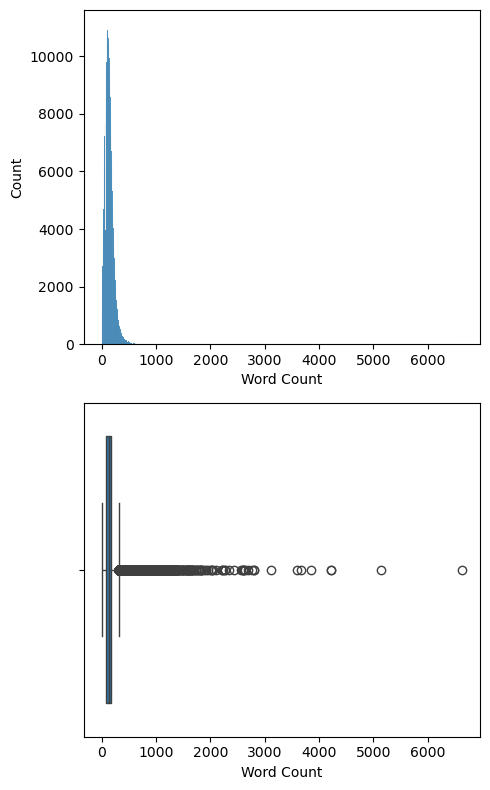

In [16]:
%matplotlib inline

df_dedup['description_word_counts'] = df_dedup['description_word_counts'].astype('Int64')
print(df_dedup['description_word_counts'].describe())

fig, ax = plt.subplots(2, 1, figsize=(5, 8))

sns.histplot(x=df_dedup['description_word_counts'], ax=ax[0])
# ax[0].set_title('Histogram of Description Word Counts')
ax[0].set_xlabel('Word Count')

sns.boxplot(x=df_dedup['description_word_counts'], ax=ax[1])
# ax[1].set_title('Boxplot of Description Word Counts')
ax[1].set_xlabel('Word Count')

plt.tight_layout()
# plt.savefig('description_word_counts.png', dpi=300, bbox_inches='tight')

## Book size (number of pages)

In [17]:
df_dedup['num_pages'] = df_dedup['num_pages'].astype('Int64')

print(df_dedup['num_pages'].describe())

count      805865.0
mean      274.04073
std      236.080774
min             0.0
25%           168.0
50%           256.0
75%           352.0
max         82000.0
Name: num_pages, dtype: Float64


#### makes sense...

In [18]:
df_dedup[df_dedup['num_pages'] == df_dedup['num_pages'].max()]

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,url,image_url,book_id,ratings_count,work_id,title,title_without_series,publication_date,image_url_large,description_word_counts
882599,1616504854,5.0,[],US,eng,"[{'count': '469', 'name': 'to-read'}, {'count'...",NaN,true,4.32,NaN,...,https://www.goodreads.com/book/show/18193089-r...,https://images.gr-assets.com/books/1373778502m...,18193089,15.0,26527011,Rogue on the Rollaway,Rogue on the Rollaway,2013-10-01,https://images.gr-assets.com/books/1373778502l...,189


## Handling the outliers
I use the Inter Quartile Range (IQR) rule to check for outliers, which is what the boxplot also uses, which bounds the data with $\mu \pm 1.5 * IQR$. This is 2.9% of the total data, however many of the 'outliers' still have a reasonable word count, so we don't just want to drop them. Also because we are using a multimodal model, it will be good to train it on instances where the description is small or very large, as they are very much possible instances.

In [19]:
# col = 'description_word_counts'

# Q1 = df[col].quantile(0.25)
# Q3 = df[col].quantile(0.75)

# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
# display(outliers)
# print(len(outliers)/len(df))

## Language code
It is also interesting that the dataset is multilingual, with 214 different language codes, however the distribution is very skewed and a lot of rows are missing a language_code. As can be expected, English is the dominant language, covering 66% of the total rows that have a language code. A multilingual LLM can be used, however depending on the model, it might be necessary to drop some languages from the data. Also, it may be preferred to only train the classifier on English books, as the users of the final system likely do not want recommendations in a language other than English (or Dutch). For now it is more important to handle the missing values, which I will impute with the detected language from the description, or title if the description is NaN.

In [24]:
language_counts = df_dedup['language_code'].value_counts()
display(language_counts.describe())
top10= language_counts.sort_values(ascending=False).head(10)
display(top10)
display(round(top10.loc[['eng', 'en-US', 'en-GB']].sum()/language_counts.sum(), 3))
print('\n\nDutch books: \n', df_dedup[df_dedup['language_code'] == 'nl'].shape[0])
display(df_dedup[df_dedup['language_code'].isna()].shape, df_dedup.shape)

count       226.000000
mean       2531.008850
std       19887.427061
min           0.000000
25%           0.000000
50%           1.000000
75%          82.750000
max      292617.000000
Name: count, dtype: float64

language_code
eng      292617
ita       32530
spa       31219
en-US     29681
fre       20248
ger       18643
en-GB     14873
por       13431
nl        12413
ind       12395
Name: count, dtype: int64

0.589



Dutch books: 
 12413


(359221, 32)

(931229, 32)

In [25]:
import pandas as pd
from langdetect import detect, DetectorFactory
from tqdm.notebook import tqdm

# seed for reproducibility
DetectorFactory.seed = 749
tqdm.pandas()

# 1. Cast language_code back to a regular object (string) so you can assign arbitrary new codes
df_dedup['language_code'] = df_dedup['language_code'].astype('object')

# 2. Define your detector
def detect_language_from_description_or_title(row):
    text = row.get('description') or row.get('title') or ""
    try:
        return detect(text) if text.strip() else None
    except:
        return None

# 3. Fill only the missing ones
mask = df_dedup['language_code'].isnull()
df_dedup.loc[mask, 'language_code'] = (
    df_dedup.loc[mask]
          .progress_apply(detect_language_from_description_or_title, axis=1)
)

# 4. (Optional) If you want to go back to a categorical dtype
df_dedup['language_code'] = df_dedup['language_code'].astype('category')

# 5. Inspect
row_counts = df_dedup.groupby('language_code').size().reset_index(name='count')
display(row_counts)


  0%|          | 0/359221 [00:00<?, ?it/s]

,language_code,count
0,--,29
1,abk,4
2,ady,1
3,af,45
4,afr,178
...,...,...
181,vls,12
182,wak,2
183,wel,9
184,yid,1


In [27]:
display(row_counts.describe())
top10= row_counts.sort_values(by='count', ascending=False).head(10)
display(top10)
display(round(top10[top10['language_code'].isin(['en', 'eng', 'en-US', 'en-GB'])]['count'].sum()/row_counts['count'].sum(), 3))
print('\n\nDutch books: \n', df_dedup[df_dedup['language_code'] == 'nl'].shape[0])
print(mask.shape)

,count
count,186.000000
mean,5006.220430
std,33500.971096
min,1.000000
25%,1.250000
50%,28.000000
75%,485.750000
max,349040.000000


,language_code,count
34,en,349040
39,eng,292617
86,ita,32530
156,spa,31219
38,en-US,29681
54,fre,20248
58,ger,18643
36,en-GB,14873
134,por,13431
116,nl,12778


0.737



Dutch books: 
 12778
(931229,)


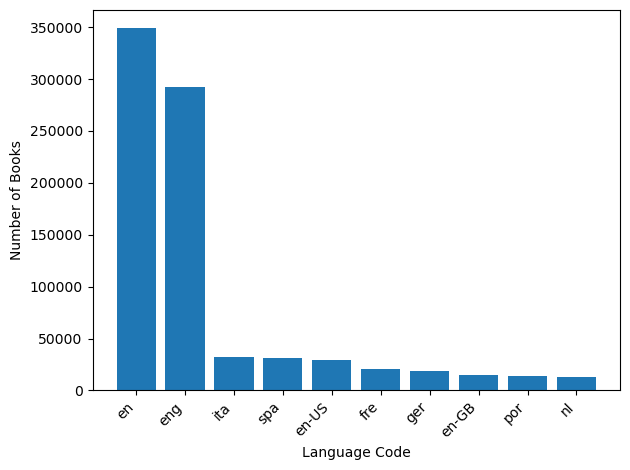

In [33]:
# 1) compute top‐10
top10 = row_counts.sort_values(by='count', ascending=False).head(10)

# 2) plot
fig, ax = plt.subplots()
ax.bar(top10['language_code'], top10['count'])
ax.set_xlabel('Language Code')
ax.set_ylabel('Number of Books')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# 3) save for LaTeX
# fig.savefig('top10_language_counts.png', dpi=300, bbox_inches='tight')

In [28]:
display(df_dedup.shape)

(931229, 32)

In [29]:
df_dedup.to_parquet("preprocessed_books_2025_04_20.parquet", index=False, compression="snappy")